In [13]:
# !pip install fastai
# !pip install fastbook

In [24]:
from fastcore.all import *
from fastbook import search_images_ddg
from fastdownload import download_url

Refactoring `search_images()` for DDG updates

In [15]:
def search_images(term, max_n=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_n)

Search images for food and hotdogs. Playing off the funny scene from Silicon Valley, we will create a classifier that determines if an image is a hotdog or not a hotdog.

In [16]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('food', max_n=1)
urls[0]

Searching for 'food'


'https://blog.amigofoods.com/wp-content/uploads/2019/04/argentinian-asado-chimichurri.jpg'

...and then download a URL and take a look at it:

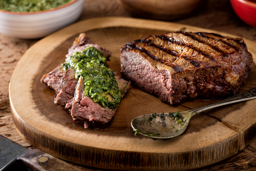

In [17]:
dest = 'not.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [19]:
searches = 'hotdog','food'
path = Path('hotdog_or_nothotdog')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'hotdog photo'
Searching for 'hotdog sun photo'
Searching for 'hotdog shade photo'


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'food photo'
Searching for 'food sun photo'
Searching for 'food shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

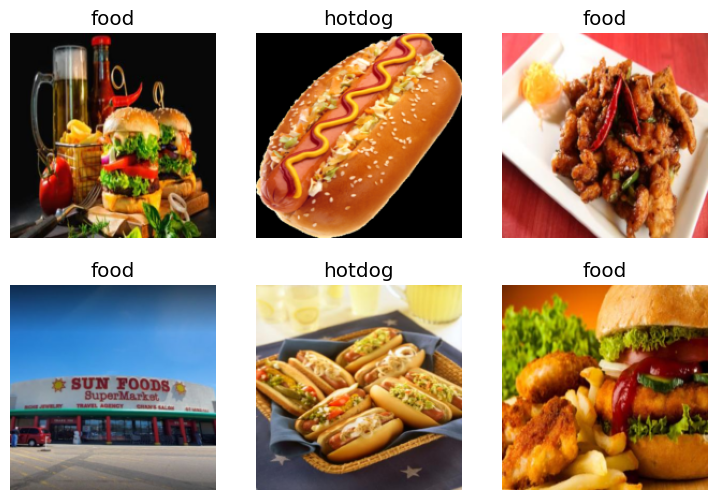

In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.018395,0.292921,0.151515,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.289373,0.154823,0.090909,00:07
1,0.213489,0.060859,0.000000,00:07
2,0.154433,0.056132,0.000000,00:07


In [23]:
not_hotdog,_,probs = learn.predict(PILImage.create('bird1.jpg'))
print(f"This is a: {not_hotdog}.")
print(f"Probability it's not a hotdog: {probs[0]:.4f}")

This is a: food.
Probability it's not a hotdog: 0.9983
